In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import scipy.io as sio

2023-07-31 13:33:57.751334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 13:33:58.757093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-07-31 13:33:58.757109: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-31 13:34:01.742097: W tensorflow/compiler/xla/stream_executor/platform/default/ds

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11780235628422602212
xla_global_id: -1
]


2023-07-31 13:34:09.318283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 13:34:09.392444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 13:34:09.392672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-07-31 13:34:09.395052:

Number of 6s in the new dataset: 39
Number of 0s in the new dataset: 5923


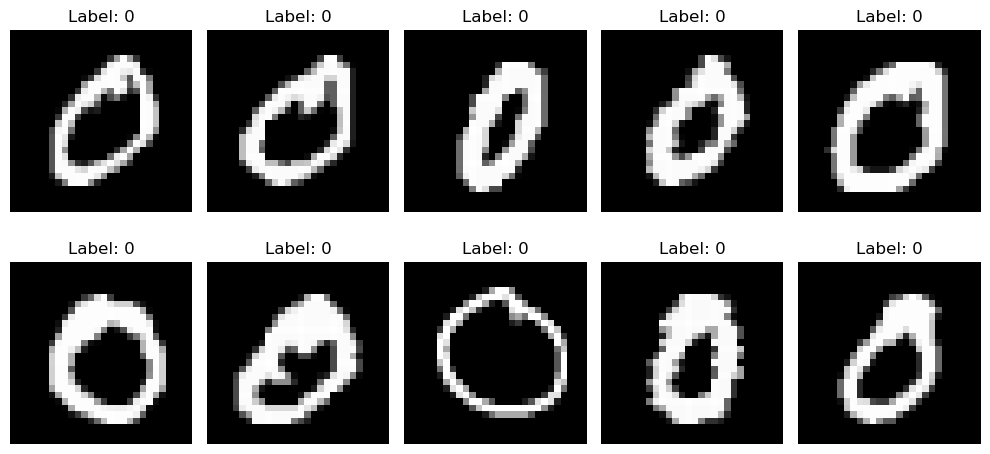

In [102]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter 6s from the dataset
indices_6 = np.where(y_train == 0)[0]
filtered_images = x_train[indices_6]
filtered_labels = y_train[indices_6]

# Select a few 0s
indices_0 = np.where(y_train == 6)[0][:len(indices_6) // 150]  # Select 1/5th of the number of 6s
selected_images = x_train[indices_0]
selected_labels = y_train[indices_0]

# Combine the selected images (6s) with the few 0s
combined_images = np.concatenate((filtered_images, selected_images))
combined_labels = np.concatenate((filtered_labels, selected_labels))

# Count the occurrences of each label (6 or 0) in the combined dataset
num_6s = np.sum(combined_labels == 6)
num_0s = np.sum(combined_labels == 0)

# Display the counts
print(f"Number of 6s in the new dataset: {num_6s}")
print(f"Number of 0s in the new dataset: {num_0s}")

# Visualize some samples from the custom dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(combined_images[i], cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the custom dataset
np.savez_compressed('custom_mnist.npz', images=combined_images, labels=combined_labels)


Shape of reshaped images: (5962, 784)


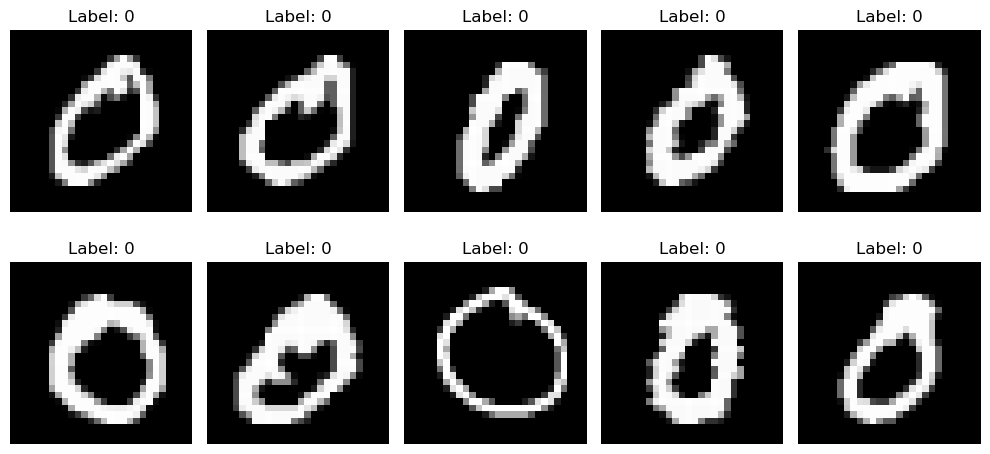

Original dataset shape: (5962, 28, 28)
Downsampled dataset shape: (5962, 15, 15)


In [103]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
# Load the custom dataset
custom_dataset = np.load('custom_mnist.npz')
combined_images = custom_dataset['images']
combined_labels = custom_dataset['labels']

# Reshape the images as 1D arrays
num_images = len(combined_images)
image_size = combined_images.shape[1] * combined_images.shape[2]
reshaped_images = combined_images.reshape(num_images, image_size)

# Display the shape of the reshaped images
print("Shape of reshaped images:", reshaped_images.shape)

# Visualize some reshaped images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(reshaped_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

output_size = (15, 15)

downsampled_images = np.zeros((combined_images.shape[0], *output_size))

# Downsample each image in the dataset
for i, image in enumerate(combined_images):
    downsampled_images[i] = zoom(image, (output_size[0] / image.shape[0], output_size[1] / image.shape[1]))

image_size = downsampled_images.shape[1] * downsampled_images.shape[2]
reshaped_images = downsampled_images.reshape(num_images, image_size)

# Verify the shape of the downsampled images
print("Original dataset shape:", combined_images.shape)
print("Downsampled dataset shape:", downsampled_images.shape)

normalized_images = reshaped_images / 255.0


# Training the VAE

In [134]:


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 5

encoder_inputs = keras.Input(shape=(225,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(225, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
#             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
#             
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss +  0.01 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# mnist_data = mat_data['X']
tdata = np.concatenate([normalized_images], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
history = vae.fit(tdata, epochs=100, batch_size=1024)

Epoch 1/100
6/6 [==============================] - 1s 10ms/step - loss: 0.1241 - reconstruction_loss: 0.1114 - kl_loss: 0.0112
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0709 - reconstruction_loss: 0.0677 - kl_loss: 0.0735
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0615 - reconstruction_loss: 0.0612 - kl_loss: 0.0063
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0598 - reconstruction_loss: 0.0594 - kl_loss: 0.0102
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0583 - reconstruction_loss: 0.0580 - kl_loss: 0.0062
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0569 - reconstruction_loss: 0.0567 - kl_loss: 0.0141
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0560 - reconstruction_loss: 0.0556 - kl_loss: 0.0300
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0551 - reconstruction_loss: 0.0543 - 

6/6 [==============================] - 0s 10ms/step - loss: 0.0353 - reconstruction_loss: 0.0272 - kl_loss: 0.8075
Epoch 66/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0352 - reconstruction_loss: 0.0272 - kl_loss: 0.8017
Epoch 67/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0351 - reconstruction_loss: 0.0271 - kl_loss: 0.8029
Epoch 68/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0351 - reconstruction_loss: 0.0271 - kl_loss: 0.8021
Epoch 69/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0351 - reconstruction_loss: 0.0270 - kl_loss: 0.8077
Epoch 70/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0351 - reconstruction_loss: 0.0270 - kl_loss: 0.8031
Epoch 71/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0350 - reconstruction_loss: 0.0269 - kl_loss: 0.8134
Epoch 72/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0351 - reconstruction_loss: 0.0270 - kl_lo

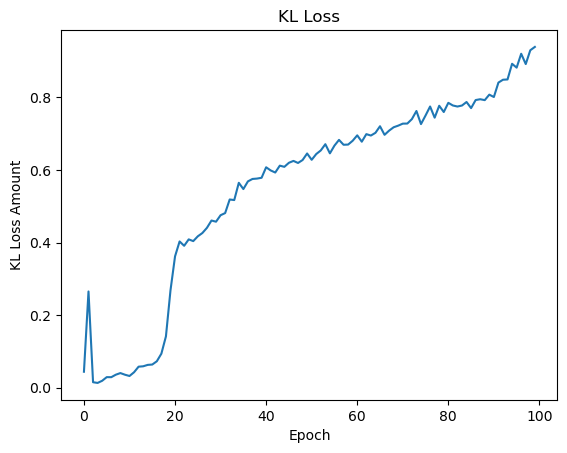

In [124]:
plt.plot(history.history['kl_loss'])
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Loss Amount')
plt.show()

In [137]:
out_rec = []

for i in range(combined_labels.shape[0]):
    
    if combined_labels[i] == 6:
        
        sample = normalized_images[i,:].reshape([1,225])

        z_mean, z_log_var, z = vae.encoder(sample)
        reconstruction = vae.decoder(z)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss +  0.08 * kl_loss

        
        out_rec.append(reconstruction_loss.numpy())

print("Mean = ", np.mean(np.array(out_rec)))
print("Std = ", np.std(np.array(out_rec)))

Mean =  0.047633547
Std =  0.012197709


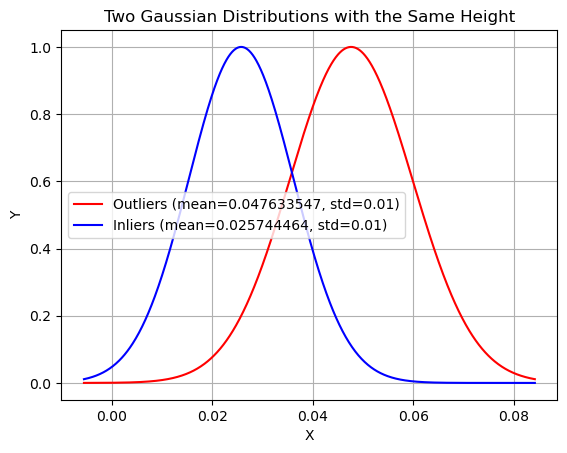

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage:
mean1 = 0.047633547
std1 = 0.012197709
mean2 = 0.025744464
std2 = 0.010438195

def gaussian(x, mean, std_dev, amplitude):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))

# Parameters for the first Gaussian distribution
# mean1 = 5
std_dev1 = std1
amplitude1 = 1

# Parameters for the second Gaussian distribution
# mean2 = 8
std_dev2 = std2
amplitude2 = 1

# Generate x values
x = np.linspace(min(mean1 - 3 * std_dev1, mean2 - 3 * std_dev2), max(mean1 + 3 * std_dev1, mean2 + 3 * std_dev2), 1000)

# Calculate y values for both Gaussian distributions
y1 = gaussian(x, mean1, std_dev1, amplitude1)
y2 = gaussian(x, mean2, std_dev2, amplitude2)

# Plot the Gaussian distributions
plt.plot(x, y1, label=f"Outliers (mean={mean1}, std={std_dev1:.2f})", color='red')
plt.plot(x, y2, label=f"Inliers (mean={mean2}, std={std_dev2:.2f})", color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Two Gaussian Distributions with the Same Height')
plt.legend()
plt.grid(True)
plt.show()


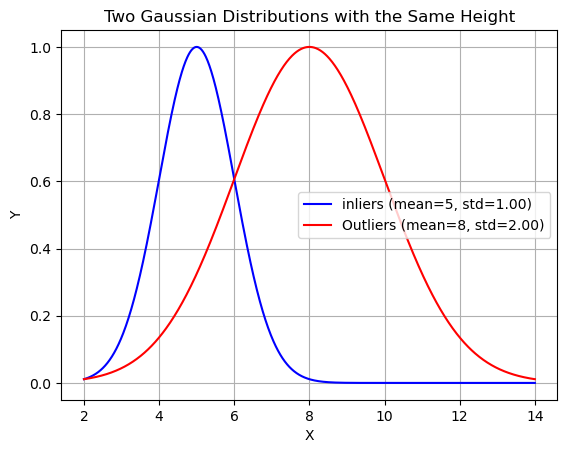

In [76]:
def gaussian(x, mean, std_dev, amplitude):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))

# Parameters for the first Gaussian distribution
mean1 = 5
std_dev1 = 1
amplitude1 = 1

# Parameters for the second Gaussian distribution
mean2 = 8
std_dev2 = 2
amplitude2 = 1

# Generate x values
x = np.linspace(min(mean1 - 3 * std_dev1, mean2 - 3 * std_dev2), max(mean1 + 3 * std_dev1, mean2 + 3 * std_dev2), 1000)

# Calculate y values for both Gaussian distributions
y1 = gaussian(x, mean1, std_dev1, amplitude1)
y2 = gaussian(x, mean2, std_dev2, amplitude2)

# Plot the Gaussian distributions
plt.plot(x, y1, label=f"inliers (mean={mean1}, std={std_dev1:.2f})", color='blue')
plt.plot(x, y2, label=f"Outliers (mean={mean2}, std={std_dev2:.2f})", color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Two Gaussian Distributions with the Same Height')
plt.legend()
plt.grid(True)
plt.show()


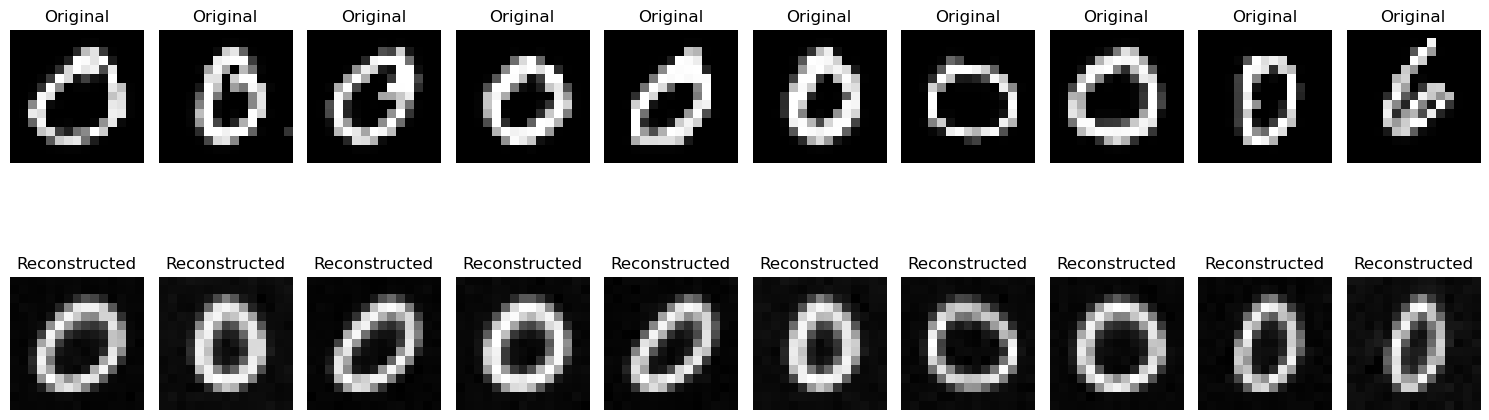

In [135]:
num_reconstructed_images = 10
indices_6 = np.where(combined_labels == 6)[0]

random_indices = np.random.choice(len(downsampled_images), num_reconstructed_images - 1, replace=False)
selected_indices = np.append(random_indices, indices_6[0])
selected_images = normalized_images[selected_indices]

# Reconstruct the selected images using the VAE
reconstructed_images = []

for i in range(num_reconstructed_images):
    
    sample = selected_images[i].reshape([1,225])
    
    z_mean, z_log_var, z = vae.encoder(sample)
    reconstruction = vae.decoder(z)
    
    reconstructed_images.append(reconstruction)

reconstructed_images = np.array(reconstructed_images)
# Display the original and reconstructed images side by side
plt.figure(figsize=(15, 6))
for i in range(num_reconstructed_images):
    plt.subplot(2, num_reconstructed_images, i + 1)
    plt.imshow(selected_images[i].reshape(15, 15), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_reconstructed_images, i + num_reconstructed_images + 1)
    plt.imshow(reconstructed_images[i].reshape(15, 15), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [45]:
selected_indices

array([2685, 2806, 1924, 4333,  219, 4589, 3539, 3923, 5260, 5923])

Indices of 6s: [5923 5924 5925 5926 5927 5928 5929 5930 5931 5932 5933 5934 5935 5936
 5937 5938 5939 5940 5941 5942 5943 5944 5945 5946 5947 5948 5949 5950
 5951 5952 5953 5954 5955 5956 5957 5958 5959 5960 5961]


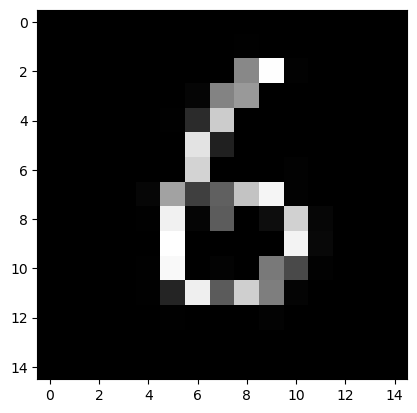

In [31]:
indices_6 = np.where(combined_labels == 6)[0]

# Display the indices of 6s
print("Indices of 6s:", indices_6)
plt.imshow(normalized_images[indices_6[1]].reshape(15, 15), cmap='gray')

In [18]:
normalized_images.shape

(6515, 225)

In [ ]:
# sols = []

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="VAE_Outlier_GA_MNIST_subspace_detection_1",
    
#     # track hyperparameters and run metadata
# #     config={
# #     "learning_rate": 0.02,
# #     "architecture": "CNN",
# #     "dataset": "CIFAR-100",
# #     "epochs": 20,
# #     }
# )

# for out_number in range(100):

def fitness_func_avg(ga_instance, solution, solution_idx):

    inliers = normalized_images[10:13]

    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,225])

    particle = normalized_images[indices_6[1]]
    particle = particle.reshape([1,225])

#     abn_subspace = solution * val_features[6728,:]

#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []

    for index in range(inliers.shape[0]):

        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,225])

        in_remain = candidate_inlier * solution

        in_normal_subspace = 1 - solution

        in_replace = in_normal_subspace * avg_ins

        in_candidate = in_remain + in_replace

        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)


        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

        avg_in_rec.append(rec_loss.numpy())

    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)





#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_remain = particle * solution

    out_normal_subspace = 1 - solution

    out_replace = avg_ins * out_normal_subspace

    out_candidate = out_remain + out_replace


    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)

    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()

    fitness = rec_loss / avg_in_rec

    return fitness


def fitness_func_avg_with_penalty(ga_instance, solution, solution_idx):

    inliers = normalized_images[10:13]

    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,225])

    particle = normalized_images[indices_6[1]]
    particle = particle.reshape([1,225])

#     abn_subspace = solution * val_features[6728,:]

#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []

    for index in range(inliers.shape[0]):

        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,225])

        in_remain = candidate_inlier * solution

        in_normal_subspace = 1 - solution

        in_replace = in_normal_subspace * avg_ins

        in_candidate = in_remain + in_replace

        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)


        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

        avg_in_rec.append(rec_loss.numpy())

    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)





#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_remain = particle * solution

    out_normal_subspace = 1 - solution

    out_replace = avg_ins * out_normal_subspace

    out_candidate = out_remain + out_replace


    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)

    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()

    fitness = rec_loss / avg_in_rec

    # adding the penalty here!

    num_ones = np.count_nonzero(solution == 1)

    penalty_rate = 1.0/normalized_images.shape[1]

#     fitness = fitness - num_ones * penalty_rate * fitness
    fitness = fitness * (1 / (num_ones + 1))

    return fitness

def on_generation(ga):
    print("Generation", ga.generations_completed)

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    print(solution_fitness)


fitness_function = fitness_func_avg

num_generations = 100
num_parents_mating = 4

sol_per_pop = 100
num_genes = 225

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

space = [[0,1] for i in range(num_genes)]

crossover_type = "uniform"

mutation_type = "random"
# mutation_percent_genes = 10
mutation_probability = 0.1

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
#                        keep_elitism=5,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability = mutation_probability,
#                        mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       gene_space = space)
ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
# print("^^^^^^^^^^^^^^^^^^^^^^^^^^ ", out_number, " ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

# wandb.log({"Solution/subspace": solution})

# sols.append(solution)
    

Generation 1
2.9701931
Generation 2
2.5746224
Generation 3
3.3075492
Generation 4
3.3075492
Generation 5
3.3075492
Generation 6
3.3075492
Generation 7
3.3075492
Generation 8
3.3075492
Generation 9
3.3075492
Generation 10
3.3075492
Generation 11
3.3075492
Generation 12
3.3075492
Generation 13
3.3075492
Generation 14
3.3075492
Generation 15
3.3075492
Generation 16
3.354952
Generation 17
3.354952
Generation 18
3.354952
Generation 19
3.354952
Generation 20
3.354952
Generation 21
3.354952
Generation 22
3.3613684
Generation 23
3.3613684
Generation 24
3.3613684
Generation 25
3.3613684
Generation 26
3.3613684
Generation 27
3.3613684
Generation 28
3.3613684
Generation 29
3.3613684
Generation 30
3.3613684
Generation 31
3.3613684
Generation 32
3.3613684
Generation 33
3.3613684
Generation 34
3.3613684
Generation 35
3.3613684
Generation 36
3.3613684
Generation 37
3.3613684


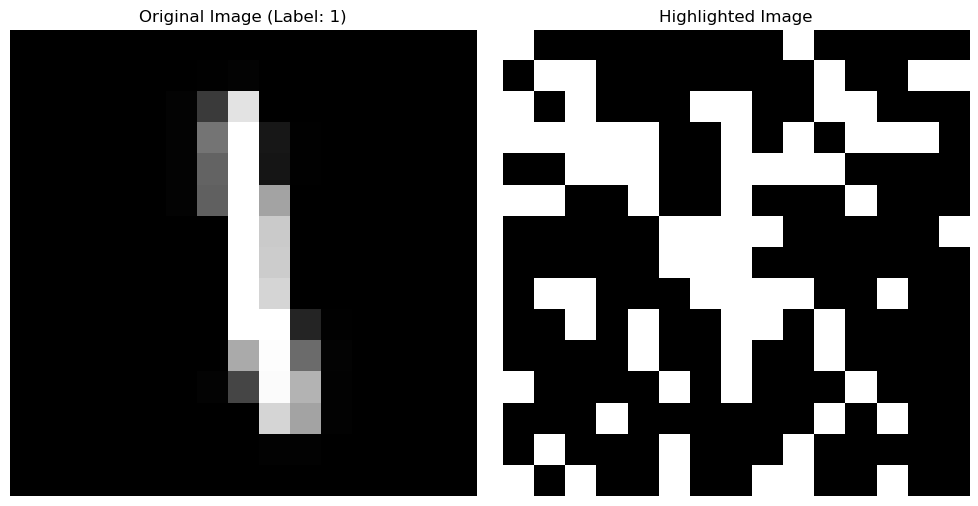

In [193]:
image = normalized_images[indices_6[1]]

# Assume you have a 1D binary array indicating some pixels (replace this with your 1D binary array)
binary_array_1d = np.array(solution)

cond = binary_array_1d == 1
bad_inds = np.where(cond)

# Convert the 1D binary array back to a 2D binary mask
image_shape = image.shape
binary_array_2d = binary_array_1d.reshape(15,15)

# Create a copy of the image to avoid modifying the original image
# highlighted_image = np.copy(normalized_images[indices_6[0]])
highlighted_image = np.zeros(225)
highlighted_image[bad_inds] = 255
highlighted_image = highlighted_image.reshape(15,15)
# Set the pixels indicated by the binary mask to a specified color (e.g., blue)
# highlighted_image[binary_array_2d == 1] = 255   # R: 0, G: 0, B: 255 (blue color)

# Plot the original image and the highlighted image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(15,15), cmap='gray')
plt.title(f'Original Image (Label: {combined_labels[indices_6[0]]})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(highlighted_image, cmap='gray')
plt.title('Highlighted Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [104]:
bad_inds

(array([  0,   9,  16,  17,  25,  28,  29,  30,  32,  36,  37,  40,  41,
         45,  46,  47,  48,  49,  52,  54,  56,  57,  58,  62,  63,  64,
         67,  68,  69,  70,  75,  76,  79,  82,  86,  95,  96,  97,  98,
        104, 110, 111, 112, 121, 122, 126, 127, 128, 129, 132, 137, 139,
        142, 143, 145, 154, 157, 160, 165, 170, 172, 176, 183, 190, 192,
        196, 200, 204, 210, 212, 215, 218, 219, 222]),)

In [191]:
my_sol = np.zeros((1,225))
my_sol[0,112:114] = 1
# my_sol = np.ones((1,225))


inliers = normalized_images[10:13]

avg_ins = np.mean(inliers, axis=0)
avg_ins = avg_ins.reshape([1,225])

particle = normalized_images[indices_6[1]]
particle = particle.reshape([1,225])

#     abn_subspace = solution * val_features[6728,:]

#     abn_subspace = abn_subspace.reshape([1,30])
fitness_avg = []

for j in range(10):

    avg_in_rec = []

    for index in range(inliers.shape[0]):

        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,225])

        in_remain = candidate_inlier * my_sol

        in_normal_subspace = 1 - my_sol

        in_replace = in_normal_subspace * avg_ins

        in_candidate = in_remain + in_replace

        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)


        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

        avg_in_rec.append(rec_loss.numpy())

    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

    out_remain = particle * my_sol

    out_normal_subspace = 1 - my_sol

    out_replace = avg_ins * out_normal_subspace

    out_candidate = out_remain + out_replace


    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)

    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()

    fitness = rec_loss / avg_in_rec
    
    fitness_avg.append(fitness)

fitness_avg = np.array(fitness_avg)
fit_avg = np.mean(fitness_avg)
# adding the penalty here!

# num_ones = np.count_nonzero(my_sol == 1)

# penalty_rate = 1.0/normalized_images.shape[1]

# #     fitness = fitness - num_ones * penalty_rate * fitness
# fitness = fitness * (1 / (num_ones + 1))


In [192]:
fit_avg

1.3018414